In [1]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac_hals
from tlgcp import generalized_parafac, stochastic_generalized_parafac
import matplotlib.pyplot as plt
from tensorly.metrics import RMSE
from tlgcp.utils import loss_operator
import time

def each_iteration(a, b):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.plot(b)
    plt.yscale('log')
    plt.legend(['GCP','S-GCP'], loc='upper right') 

np.set_printoptions(precision=2)

# Example with Bernoulli loss
# --------------------------------------------
To use GCP decomposition efficiently, loss should be selected according to the input tensor.
Here, we will report an example with Bernoulli odds loss. Let us note that
we suggest to use random init rather than svd while using GCP decomposition.

In [2]:
# Parameters
init = 'random'
rank = 5
loss = 'bernoulli_odds'
shape = [60, 80, 50]

To create a synthetic tensor wih Bernoulli distribution, we use random cp and numpy
binomial functions:

In [3]:
cp_tensor = tl.cp_to_tensor(tl.random.random_cp(shape, rank))
array = np.random.binomial(1, cp_tensor / (cp_tensor + 1), size=shape)
tensor = tl.tensor(array, dtype='float')

In [4]:
tic = time.time()
tensor_gcp, errors_gcp = generalized_parafac(tensor, rank=rank, init=init, return_errors=True, loss=loss,
                                             n_iter_max=100)
cp_reconstruction_gcp = tl.cp_to_tensor((tensor_gcp))
time_gcp = time.time() - tic

Stochastic GCP (SGCP) decomposition function requires batch size, epochs and beta
parameters (for ADAM) as input in addition to GCP decomposition inputs. Fortunately,
LR and beta parameters could be fixed thanks to the literature who works with
ADAM optimization. Besides, in case of badly chosen LR, SGCP updates the LR by dividing
LR by 10 after each failed iteration until reaching 20 successive bad iteration.

In [5]:
tic = time.time()
tensor_sgcp, errors_sgcp = stochastic_generalized_parafac(tensor, rank=rank, init=init,
                                                          return_errors=True, loss=loss, lr=1e-3,
                                                          n_iter_max=1000, batch_size=50, epochs=100)
cp_reconstruction_sgcp = tl.cp_to_tensor((tensor_sgcp))
time_sgcp = time.time() - tic

Sufficient number of bad epochs


To compare GCP decompositions, we choose non-negative CP with HALS (NN-CP)
since Bernoulli odds has a non-negative constraint.

In [6]:
tic = time.time()
tensor_cp, errors = non_negative_parafac_hals(tensor, rank=rank, n_iter_max=100, init=init, return_errors=True)
cp_reconstruction = tl.cp_to_tensor((tensor_cp))
time_cp = time.time() - tic

In the example, we use binary tensor `tensor` as an input. It is possible to
have binary result by using numpy binomial function on reconstructed cp tensors.
Besides, we could compare the results with initial `cp_tensor` and reconstructed tensors
without calculating it.

In [7]:
print("RMSE for GCP:", RMSE(cp_tensor, cp_reconstruction_gcp))
print("RMSE for SGCP:", RMSE(cp_tensor, cp_reconstruction_sgcp))
print("RMSE for NN-CP:", RMSE(cp_tensor, cp_reconstruction))

print("Loss for GCP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction_gcp, loss)))
print("Loss for SGCP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction_sgcp, loss)))
print("Loss for NN-CP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction, loss)))

print("GCP time:", time_gcp)
print("SGCP time:", time_sgcp)
print("NN-CP time:", time_cp)

RMSE for GCP: 0.09003327802357115
RMSE for SGCP: 0.11195938882885624
RMSE for NN-CP: 0.3193514827107897
Loss for GCP: 0.6900767661529167
Loss for SGCP: 0.6990849797883826
Loss for NN-CP: 0.8699653939402862
GCP time: 1.5876233577728271
SGCP time: 13.842896699905396
NN-CP time: 0.4187164306640625


We compare the results according to processing time, root mean square error and
the selected loss. According to the final Bernoulli loss,
both GCP and SGCP give better results than NN-CP. Since SGCP requires many
iteration inside each epoch, processing time is much more than the others.

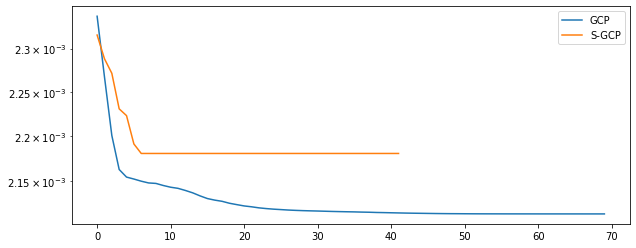

In [8]:
each_iteration(errors_gcp, errors_sgcp)